#[PyTorch Tutorial](https://pytorch.org/tutorials/index.html)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

## 1. Load and normalizing the datasets using torchvision

The output of torchvision datasets are PILImage images of range [0, 1].



In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=8)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## 2. Define a Convolution Neural Network



##### Net w/ Dropout
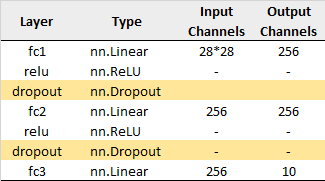

In [15]:
class Net_with_dropout(nn.Module):
    def __init__(self, num_classes=10):
        super(Net_with_dropout, self).__init__()
        #########################################
        #
        #                your code
        # 
        self.fc1 = nn.Linear(28*28,256)
        self.fc2 = nn.Linear(256,256)
        self.fc3 = nn.Linear(256,10)
        self.dropout = nn.Dropout()
        #########################################
    def forward(self, x):
        #########################################
        #
        #                your code
        #
        # MNIST input size : (1 x 28 x 28) 
        #
        x = x.view(x.size(0),-1)
        out = self.fc1(x)
        out = F.relu(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = F.relu(out)
        out = self.dropout(out)

        out = self.fc3(out)
        # 
        # 
        #########################################
        return out

##### Net w/o Dropout

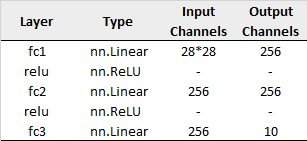

In [ ]:
class Net_without_dropout(nn.Module):
    def __init__(self, num_classes=10):
        super(Net_without_dropout, self).__init__()
        #########################################
        #
        #                your code
        #
        self.fc1 = nn.Linear(28*28,256)
        self.fc2 = nn.Linear(256,256)
        self.fc3 = nn.Linear(256,10)
        #
        # 
        # 
        #########################################
    def forward(self, x):
        #########################################
        #
        #                your code
        #
        # MNIST input size : (1 x 28 x 28) 
        #
        x = x.view(x.size(0),-1)
        out = self.fc1(x)
        out = F.relu(out)

        out = self.fc2(out)
        out = F.relu(out)

        out = self.fc3(out)
        # 
        #########################################
        return out

In [16]:
net = Net_with_dropout()
# net = Net_without_dropout()
net = net.cuda()

## 3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)

## 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [18]:
import time

epochs = 15

for epoch in range(epochs):  # loop over the dataset multiple times

    net.train()

    running_loss = 0.0
    start = time.time()

    correct = 0
    total = 0
    for i, data in enumerate(tqdm(trainloader)):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        B, _, H, W = inputs.shape
        inputs = inputs.view(B, H*W)

        # forward + backward + optimize
        outputs = net(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()

    end = time.time()
    print('(Train) [epoch : %d] loss: %.3f / time: %.3f / acc@1: %.3f' %
          (epoch + 1, running_loss / len(trainloader), (end-start), 100 * correct / total))

    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()

            B, _, H, W = inputs.shape
            inputs = inputs.view(B, H*W)

            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('(Test) Accuracy of the network on the 10000 test images: %.3f %%\n' % (
        100 * correct / total))

print('Finished Training')

  0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(Train) [epoch : 1] loss: 0.950 / time: 12.943 / acc@1: 67.925


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 83.960 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 2] loss: 0.559 / time: 13.111 / acc@1: 81.912


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 87.910 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 3] loss: 0.463 / time: 12.756 / acc@1: 85.387


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 88.940 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 4] loss: 0.402 / time: 12.871 / acc@1: 87.368


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 92.280 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 5] loss: 0.360 / time: 12.836 / acc@1: 88.800


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 92.570 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 6] loss: 0.336 / time: 12.995 / acc@1: 89.568


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 93.420 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 7] loss: 0.318 / time: 12.897 / acc@1: 90.110


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 93.640 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 8] loss: 0.302 / time: 12.781 / acc@1: 90.720


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 93.680 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 9] loss: 0.286 / time: 12.902 / acc@1: 91.152


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 94.250 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 10] loss: 0.279 / time: 13.615 / acc@1: 91.453


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 94.330 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 11] loss: 0.264 / time: 12.776 / acc@1: 91.953


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 94.660 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 12] loss: 0.256 / time: 14.062 / acc@1: 92.253


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 95.190 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 13] loss: 0.251 / time: 12.996 / acc@1: 92.272


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 94.100 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 14] loss: 0.245 / time: 12.859 / acc@1: 92.470


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 95.220 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 15] loss: 0.239 / time: 13.038 / acc@1: 92.575


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 95.100 %

Finished Training
